In [1]:
import logging
import os
import pdb
import warnings
from pathlib import Path
from typing import Tuple, Union

import cartopy
import matplotlib.pyplot as plt

# import metplotpy.contributed.fv3_physics_tend
import numpy as np
import pandas as pd
import xarray
from metpy.units import units
from scipy.interpolate import griddata
from utils import fmt, get_obsds, getfcst, getobs, tissot

warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

In [2]:
casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")
workdir = Path("/glade/derecho/scratch/ahijevyc/ks21_tmp")


def subset_lonlat(df):
    df.loc[df["LON(E)"] >= 180, "LON(E)"] = df.loc[df["LON(E)"] >= 180, "LON(E)"] - 360
    lat = df["LAT(N)"]
    lon = df["LON(E)"]
    df = df[lat.between(lat0, lat1) & lon.between(lon0, lon1)]
    return df


isensemble = False

datepos = 0
F024 = sorted(casedir.glob(f"[12]?????????.F024.C768"))
if isensemble:
    F024 = sorted(casedir.glob(f"E[12]?????????.p??.F024.C768"))
    datepos = 1


itimes = pd.Series(
    [pd.to_datetime(c.name[datepos : datepos + 10], format=fmt) for c in F024],
    name="initialization_time",
)

case_dates = itimes + pd.to_timedelta("24h")

print(f"found {len(case_dates)} cases in casedir {casedir}")

# Choose an initialization time index
# 10 in Lupo2023
# 6 in May Wong's Jupyter notebook
case_index = 6
case = case_dates[case_index]

logging.info(f"chose case={case}")

pd.Series(case_dates, name="case")

found 24 cases in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw


0    2019-10-26 06:00:00
1    2019-11-27 06:00:00
2    2019-12-23 00:00:00
3    2020-02-12 06:00:00
4    2020-02-23 12:00:00
5    2020-03-04 00:00:00
6    2020-04-09 12:00:00
7    2020-04-12 12:00:00
8    2020-05-19 12:00:00
9    2020-09-01 18:00:00
10   2020-09-10 00:00:00
11   2020-10-28 18:00:00
12   2020-11-28 06:00:00
13   2021-03-17 18:00:00
14   2021-04-12 00:00:00
15   2021-04-14 12:00:00
16   2021-05-01 06:00:00
17   2021-10-19 18:00:00
18   2021-10-29 06:00:00
19   2022-01-03 06:00:00
20   2022-02-16 12:00:00
21   2022-04-14 06:00:00
22   2022-05-05 12:00:00
23   2022-06-14 18:00:00
Name: case, dtype: datetime64[ns]

In [3]:
def assign_time(ds: xarray.Dataset):
    """convert Times variable to datetime and assign to coordinate
    same with initialization_time"""

    # remove one-element-long Time dimension
    # It has no value associated with it.
    ds = ds.squeeze(dim="Time", drop=True)

    logging.info("decode valid_time variable")
    fmt = "%Y-%m-%d_%H:%M:%S"
    valid_time = pd.to_datetime(
        ds["Times"].load().item().decode("utf-8").strip(),
        format=fmt,
    )

    # assign initialization time variable to its own coordinate
    ds = ds.assign_coords(
        valid_time=(
            ["valid_time"],
            [valid_time],
        ),
    )

    initialization_time = pd.to_datetime(ds.attrs["SIMULATION_START_DATE"], format=fmt)

    ds["fhr"] = (valid_time - initialization_time) / pd.to_timedelta("1h")

    ds = ds.expand_dims(initialization_time=[initialization_time])

    return ds

In [4]:
parallel = True
if parallel:
    try:
        client.cluster.close()
        client.shutdown()
        client.close()
    except:
        pass

    from dask.distributed import Client

    client = Client(n_workers=4)
    client

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41451
INFO:distributed.scheduler:  dashboard at:  https://jupyterhub.hpc.ucar.edu/stable/user/ahijevyc/proxy/8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42413'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37201'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34855'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41183'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42177', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42177
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:49490
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40159', name: 1, status: init, memory: 0, processing: 0>
INFO:distrib

In [5]:
ifiles = []
for lead_time in [24, 48, 72, 96]:
    initialization_time = case - lead_time * pd.to_timedelta("1h")
    forecast_length = lead_time if lead_time != 96 else 240
    FHR = f"F{forecast_length:03d}"
    gen = (casedir / f"{initialization_time.strftime('%Y%m%d%H')}.{FHR}.C768").glob(
        "interp/interp_fv3_history2d_*_f0??.nc"
    )  # ignore forecast hours over 96. with f0??
    ifiles.extend(list(gen))
ifiles = sorted(ifiles)

logging.warning(f"opening {len(ifiles)} files")
ds = xarray.open_mfdataset(
    ifiles,
    preprocess=assign_time,
    parallel=True,
    compat="override",
    coords="minimal",
    combine_attrs="drop_conflicts",
)
logging.warning(f"opened {len(ifiles)} files")
logging.info(ifiles)

# Take 1-d lat and 1-d lon coordinates from 2-d XLONG and XLAT
lon = ds.XLONG.isel(south_north=0).values
# lon = np.roll(np.arange(-180, 180, 0.25)+0.25, 360*2+1)
lat = ds.XLAT.isel(west_east=0).values
# lat = np.linspace(90, -90, 180*4+1)
assert all(np.diff(lat) < 0), "expected lat to decrease monotonically"
ds = ds.rename_dims(south_north="lat", west_east="lon").assign_coords(
    lon=("lon", lon), lat=("lat", lat)
)
ds = ds.sortby(["lon", "lat"])
ds

<xarray.Dataset> Size: 161GB
Dimensions:              (valid_time: 16, initialization_time: 4, lat: 721,
                          lon: 1440)
Coordinates:
  * initialization_time  (initialization_time) datetime64[ns] 32B 2020-04-05T...
  * valid_time           (valid_time) datetime64[ns] 128B 2020-04-05T18:00:00...
    XLONG                (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    XLAT                 (lat, lon) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
  * lon                  (lon) float32 6kB -179.8 -179.5 -179.2 ... 179.8 180.0
  * lat                  (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.75 90.0
Data variables: (12/606)
    Times                (valid_time, initialization_time) object 512B b'2020...
    us                   (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    vs                   (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u1000                (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u925                 (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    u850                 (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    ...                   ...
    vbdsf_ave            (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    vddsf_ave            (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    nbdsf_ave            (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    nddsf_ave            (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    trans_ave            (valid_time, initialization_time, lat, lon) float32 266MB dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
    fhr                  (valid_time, initialization_time) float64 512B 6.0 ....
Attributes: (12/16)
    WEST-EAST_GRID_DIMENSION:    1441
    SOUTH-NORTH_GRID_DIMENSION:  722
    BOTTOM-TOP_GRID_DIMENSION:   1
    SIMULATION_START_DATE:       2020-04-05_12:00:00
    START_DATE:                  2020-04-05_12:00:00
    DX:                          27794.369140625
    ...                          ...
    MOAD_CEN_LAT:                0.0
    STAND_LON:                   0.0
    POLE_LAT:                    90.0
    POLE_LON:                    0.0
    MAP_PROJ:                    6
    MAP_PROJ_CHAR:               Lat/Lon

In [6]:
# Remember un-clipped Dataset
ds0 = ds

In [7]:
# lat dimension goes from 90 to -90 so slice starts with larger latitude.
# set extent
lon0 = -179
lon1 = 50
lat0 = -83
lat1 = 80

ds = ds.sel(lat=slice(lat0, lat1), lon=slice(lon0, lon1))

# Group variables by common prefix, extract numeric vertical levels,
# then stack them and assign the vertical level as the coordinate.
potential_plevs = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50, 10]
STATEVARS = ["omg", "q", "rh", "t", "u", "v", "z"]
TENDS = {}
TENDS["t"] = [
    "cnvgwd",
    "deepcnv",
    "lw",
    "mp",
    "nonphys",
    "ogwd",
    "pbl",
    "rdamp",
    "shalcnv",
    "sw",
]
TENDS["q"] = [
    "deepcnv",
    "mp",
    "nonphys",
    "pbl",
    "shalcnv",
]
TENDS["u"] = [
    "cnvgwd",
    "deepcnv",
    "mp",
    "nonphys",
    "ogwd",
    "pbl",
    "rdamp",
    "shalcnv",
]
TENDS["v"] = TENDS["u"]

# `omg` `rh` and `z` have no tendency
TENDS["omg"] = TENDS["rh"] = TENDS["z"] = []

for statevar in STATEVARS:
    for tend in TENDS[statevar] + [""]:
        potentialvars = [f"d{statevar}3dt{plev}_{tend}" for plev in potential_plevs]
        newvar = f"d{statevar}3dt_{tend}"
        if tend == "":
            potentialvars = [f"{statevar}{plev}" for plev in potential_plevs]
            newvar = statevar
        logging.info(newvar)
        this_vars = [var for var in potentialvars if var in ds]
        if not this_vars:
            continue
        stack = []
        for var in this_vars:
            logging.info(f"{var} {statevar} {tend}")
            plev = int(
                var.removeprefix(f"d{statevar}3dt")
                .removeprefix(statevar)
                .removesuffix(f"_{tend}")
            )
            assert plev, f"unexpected plev {plev}"
            tmpvar = ds[var].expand_dims(pfull=[plev])
            tmpvar.attrs["description"] = tmpvar.attrs["description"].lstrip(f"{plev}-mb ")
            stack.append(tmpvar)
            ds = ds.drop_vars(var)
        ds[newvar] = xarray.concat(stack, dim="pfull")


ds

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/dask/array/core.py:4832: PerformanceW

<xarray.Dataset> Size: 104GB
Dimensions:              (initialization_time: 4, valid_time: 16, lon: 917,
                          lat: 653, pfull: 14)
Coordinates:
  * initialization_time  (initialization_time) datetime64[ns] 32B 2020-04-05T...
  * valid_time           (valid_time) datetime64[ns] 128B 2020-04-05T18:00:00...
  * lon                  (lon) float32 4kB -179.0 -178.8 -178.5 ... 49.75 50.0
  * lat                  (lat) float32 3kB -83.0 -82.75 -82.5 ... 79.75 80.0
  * pfull                (pfull) int64 112B 1000 925 850 700 ... 150 100 50 10
    XLONG                (lat, lon) float32 2MB dask.array<chunksize=(653, 917), meta=np.ndarray>
    XLAT                 (lat, lon) float32 2MB dask.array<chunksize=(653, 917), meta=np.ndarray>
Data variables: (12/189)
    Times                (valid_time, initialization_time) object 512B b'2020...
    us                   (valid_time, initialization_time, lat, lon) float32 153MB dask.array<chunksize=(1, 1, 653, 917), meta=np.ndarray>
    vs                   (valid_time, initialization_time, lat, lon) float32 153MB dask.array<chunksize=(1, 1, 653, 917), meta=np.ndarray>
    albdo_ave            (valid_time, initialization_time, lat, lon) float32 153MB dask.array<chunksize=(1, 1, 653, 917), meta=np.ndarray>
    cprat_ave            (valid_time, initialization_time, lat, lon) float32 153MB dask.array<chunksize=(1, 1, 653, 917), meta=np.ndarray>
    cpratb_ave           (valid_time, initialization_time, lat, lon) float32 153MB dask.array<chunksize=(1, 1, 653, 917), meta=np.ndarray>
    ...                   ...
    dv3dt_ogwd           (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 917), meta=np.ndarray>
    dv3dt_pbl            (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 917), meta=np.ndarray>
    dv3dt_rdamp          (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 917), meta=np.ndarray>
    dv3dt_shalcnv        (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 917), meta=np.ndarray>
    v                    (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 917), meta=np.ndarray>
    z                    (pfull, valid_time, initialization_time, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 1, 653, 917), meta=np.ndarray>
Attributes: (12/16)
    WEST-EAST_GRID_DIMENSION:    1441
    SOUTH-NORTH_GRID_DIMENSION:  722
    BOTTOM-TOP_GRID_DIMENSION:   1
    SIMULATION_START_DATE:       2020-04-05_12:00:00
    START_DATE:                  2020-04-05_12:00:00
    DX:                          27794.369140625
    ...                          ...
    MOAD_CEN_LAT:                0.0
    STAND_LON:                   0.0
    POLE_LAT:                    90.0
    POLE_LON:                    0.0
    MAP_PROJ:                    6
    MAP_PROJ_CHAR:               Lat/Lon

In [8]:
def change_in_n_times(da: xarray.DataArray, n: int) -> xarray.DataArray:
    # difference from n times earlier
    # Gets rid of first n times because there is no data to subtract from them.
    if n == 0:
        return da
    assert n < da.valid_time.size, f"n must be < number of Times {da.valid_time.size}"
    assert da.attrs, "DataArray should have some attributes"
    da_attrs = da.attrs.copy()  # remember description and units
    da = da - da.shift(valid_time=n)
    dsec = (da.valid_time - da.valid_time.shift(valid_time=n)).dt.total_seconds()
    # Convert last element of dsec from seconds to hours
    dhour = dsec.item(-1) / 3600
    da.attrs.update(da_attrs)
    if da.name not in STATEVARS:
        # You might think you need to multiply `da` by time, dsec, since the
        # units of tendency in the netCDF file are units *per second*.
        # However, *per second* should not be there. Take it away below.
        da.attrs["units"] = units(da.attrs["units"]) * units.second
    da.attrs["long_name"] = f"{dhour:.0f}-h change"
    da.attrs["description"] = da.attrs["long_name"]
    return da

In [29]:
def fcst_error(da: xarray.DataArray) -> xarray.DataArray:
    # return forecast minus observed 
    if da.name not in STATEVARS:
        # You might think you need to multiply `da` by time, dsec, since the
        # units of tendency in the netCDF file are units *per second*.
        # However, *per second* should not be there. Take it away below.
        da.attrs["units"] = units(da.attrs["units"]) * units.second
    obs = []
    for valid_time in np.atleast_1d(da.valid_time.values):
        print(valid_time)
        obs.append(get_obsds(pd.to_datetime(valid_time), level=da.pfull.item()))
    err = da - xarray.concat(obs, dim="valid_time")
    return err

................

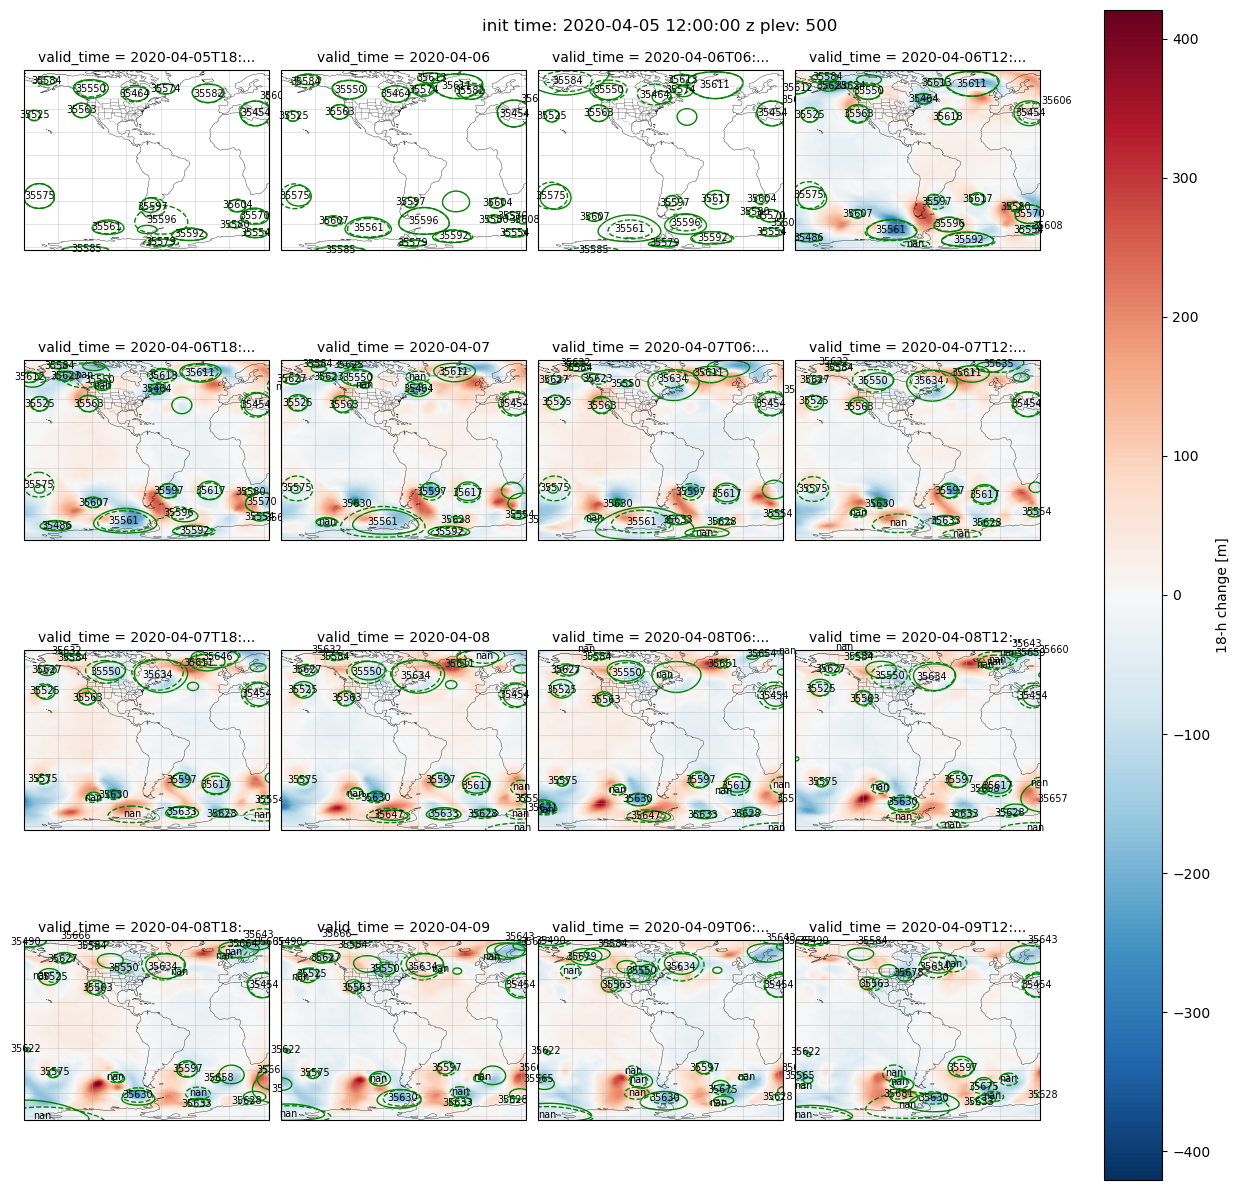

In [11]:
assert (ds.fhr.min(dim="valid_time") == 6).all(), f"first_valid time not fhr=6 {ds.fhr}"

# VARIABLE in all caps is supposed to be constant throughout script
INITIALIZATION_TIME = case - pd.to_timedelta("96h")
shiftTime = 3
var = "z"
plev = 500

da = change_in_n_times(ds[var].sel(pfull=plev), shiftTime).sel(
    initialization_time=INITIALIZATION_TIME,
    valid_time=slice(INITIALIZATION_TIME + pd.to_timedelta("6h"), case),
)

projection = cartopy.crs.PlateCarree()
p = da.plot(
    row="valid_time",
    col_wrap=4,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
)


for valid_time, ax in zip(da.valid_time, p.axs.flat):
    coastlines = ax.coastlines(lw=0.25)
    ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)
    obs = getobs(valid_time)
    fcst = getfcst(INITIALIZATION_TIME, valid_time, workdir)

    fcst = subset_lonlat(fcst)
    obs = subset_lonlat(obs)

    for i, row in fcst.iterrows():
        lat = row["LAT(N)"]
        lon = row["LON(E)"]
        ax.text(
            lon,
            lat,
            f"{row.ID:.0f}",
            ha="center",
            va="center",
            transform=cartopy.crs.PlateCarree(),
            fontsize="x-small",
        )

    tissot(ax, obs, color="green", facecolor="none")
    tissot(ax, fcst, color="green", linestyle="dashed", facecolor="none")
    ax.set_extent((lon0, lon1 - 15, lat0, lat1 - 6), crs=cartopy.crs.PlateCarree())
    ax.gridlines(lw=0.5, alpha=0.5)

s = p.fig.suptitle(f"init time: {INITIALIZATION_TIME} {var} plev: {plev}")

....

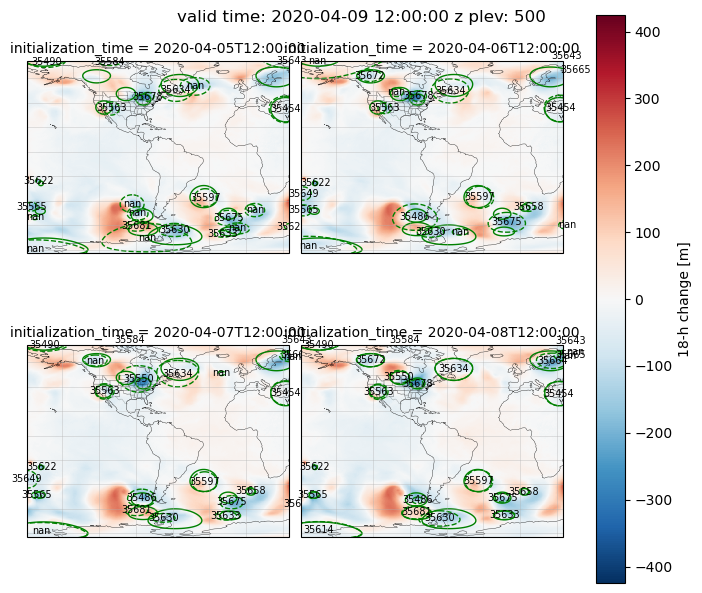

In [12]:
da = change_in_n_times(ds[var].sel(pfull=plev), shiftTime).sel(valid_time=case)

projection = cartopy.crs.PlateCarree()
p = da.plot(
    col="initialization_time",
    col_wrap=2,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
)

obs = getobs(case)
obs = subset_lonlat(obs)
for initialization_time, ax in zip(da.initialization_time, p.axs.flat):
    coastlines = ax.coastlines(lw=0.25)
    ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)
    fcst = getfcst(initialization_time, case, workdir)
    fcst = subset_lonlat(fcst)

    for i, row in fcst.iterrows():
        lat = row["LAT(N)"]
        lon = row["LON(E)"]
        ax.text(
            lon,
            lat,
            f"{row.ID:.0f}",
            ha="center",
            va="center",
            transform=cartopy.crs.PlateCarree(),
            fontsize="x-small",
        )

    tissot(ax, obs, color="green", facecolor="none")
    tissot(ax, fcst, color="green", linestyle="dashed", facecolor="none")
    ax.set_extent((lon0, lon1 - 15, lat0, lat1 - 6), crs=cartopy.crs.PlateCarree())
    ax.gridlines(lw=0.5, alpha=0.5)

p.set_titles(template="{coord} = {value}", maxchar=300)
s = p.fig.suptitle(f"valid time: {case} {var} plev: {plev}")

In [57]:
da = ds[var].sel(pfull=plev).sel(valid_time=case) - get_obsds(case, level=plev, var=var)
da.plot(
    col="initialization_time",
    col_wrap=2,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
)

ValueError: cannot rename 'longitude' because it is not a variable or dimension in this dataset

'isobaricInhPa = 500.0 [hPa], valid_time = 2020-...'

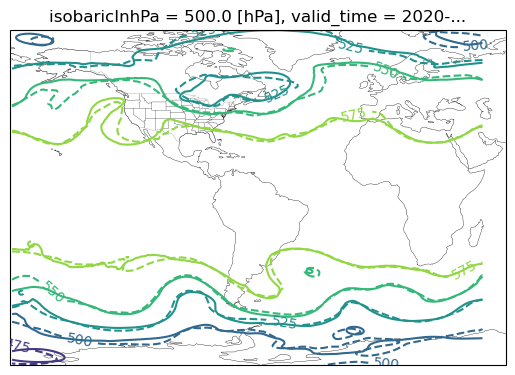

In [15]:
da = ds.z/10
f = da.sel(
    pfull=plev, initialization_time=INITIALIZATION_TIME, valid_time=valid_time
).plot.contour(
    linestyles="dashed",
    subplot_kws={"projection": projection},
)
ax = f.axes
ax.clabel(f)
obsds = get_obsds(case, level=plev)
obsds = obsds.sel(latitude=slice(lat0, lat1), longitude=slice(lon0, lon1))
# Plot contour plot
g = (obsds.gh/10).plot.contour(
    ax=ax,
    linestyles="solid",
)
coastlines = ax.coastlines(lw=0.25)
ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)
ax.get_title()

In [31]:
id = 35563#38671


da = change_in_n_times(ds[var].sel(pfull=plev), shiftTime).sel(
    initialization_time=INITIALIZATION_TIME,
    valid_time=slice(INITIALIZATION_TIME + pd.to_timedelta("6h"), case),
)

p = da.plot(
    col="valid_time",
    col_wrap=4,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
)

minlon = np.inf
maxlon = -np.inf
minlat = np.inf
maxlat = -np.inf
for valid_time, ax in zip(da.valid_time, p.axs.flat):
    coastlines = ax.coastlines(lw=0.25)
    ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)

    gl = ax.gridlines(lw=0.5, alpha=0.5, draw_labels=True)
    gl.ylabel_style = {"fontsize": 0}
    gl.top_labels = False

    obs = getobs(valid_time)
    fcst = getfcst(INITIALIZATION_TIME, valid_time, workdir)
    obs = obs[(obs.ID == id)]
    obs = subset_lonlat(obs)
    if obs.empty:
        print(f"{valid_time.data} obs empty")
        continue
    tissot(ax, obs, alpha=0.4, color="green", facecolor="none")

    fcst = subset_lonlat(fcst)
    fcst = fcst[(fcst.ID == id)]
    lat = fcst["LAT(N)"].values
    lon = fcst["LON(E)"].values
    if fcst.empty:
        print(f"{valid_time.data} fcst empty")
        continue

    alpha = 0.7
    t = tissot(ax, fcst, alpha=alpha, color="green", linestyle="dashed", facecolor="none")
    kmPerLon = 111.1 * np.cos(np.deg2rad(lat))
    (dlon,) = fcst["Ro(km)"].values / kmPerLon
    dlat = fcst["Ro(km)"].values / 111.1
    minlon = min([minlon, lon-dlon])
    maxlon = max([maxlon, lon+dlon])
    minlat = min([minlat, lat-dlat])
    maxlat = max([maxlat, lat+dlat])

    ax.set_extent((minlon-5, maxlon+5, minlat-5, maxlat+5), crs=cartopy.crs.PlateCarree())

    z500 = (ds.z / 10).sel(
        pfull=plev, initialization_time=INITIALIZATION_TIME, valid_time=valid_time
    )
    levels = np.arange(450, 600, 10)
    g = z500.plot.contour(
        ax=ax,
        linestyles="dashed",
        label="forecast",
        colors="k",
        levels=levels,
    )
    g = (
        get_obsds(pd.to_datetime(valid_time.data), level=500)
        .sel(latitude=slice(lat0, lat1), longitude=slice(lon0, lon1))
        .gh
        / 10
    ).plot.contour(
        ax=ax,
        linestyles="solid",
        colors="k",
        levels=levels,
    )
    ax.clabel(g, inline=True, inline_spacing=2, fontsize="x-small")

s = p.fig.suptitle(f"feature id: {id}  init time: {INITIALIZATION_TIME} {var} plev: {plev}")
ofile = f"{var}.{case.strftime('%Y%m%d%H')}.{shiftTime}.png"
p.set_titles(template="{coord} = {value}", maxchar=300)
p.fig.savefig(ofile)
print(ofile)

2020-04-09T12:00:00.000000000


ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

In [14]:
fcst

ITIME FHOUR       ID  So(m/100km)  LAT(N)  LON(E)  SoFlag  Ro(km)  \
18  2020040512  f096  35563.0        21.54   35.25  -110.0       0   600.0   

      SR  BGo(m/100km)  ...  PTY-OVR  FERRY(km)  FERRX(km)  FERR(km)  \
18  0.21          4.53  ...     0.42     -83.42     539.82    548.74   

    T(0)/M(1)/N  VLat(N)  VLon(E)    VSo    VRo    VZmin  
18            0     36.0    244.0  21.34  600.0  5530.88  

[1 rows x 52 columns]

In [15]:
obs

ITIME FHOUR     ID  So(m/100km)  LAT(N)  LON(E)  SoFlag  Ro(km)  \
21  2020040912  f000  35563        21.34    36.0  -116.0       0   600.0   

      SR  BGo(m/100km)  ...  DY(km)  DX(km)  DIST(km)  DT(h)  DUR(h)  \
21  0.28          5.94  ...  139.03   45.69    146.24    6.0   150.0   

    MAXDUR(h)  PTY-OVR  FERRY(km)  FERRX(km)  FERR(km)  
21      240.0     0.28        NaN        NaN       NaN  

[1 rows x 46 columns]

In [23]:
def rotate_and_interpolate_field_xarray(field, lat_a, lon_a, lat_b, lon_b):
    """
    Rotate a field defined on a set of lat/lon points and interpolate it back to the original grid.
    
    Parameters:
    - field: xarray.DataArray, field values with 2D coordinates `XLAT` (latitude) and `XLONG` (longitude),
             and optionally a `valid_time` dimension.
    - lat_a, lon_a: Latitude and longitude of the original reference point A.
    - lat_b, lon_b: Latitude and longitude of the new position B.
    
    Returns:
    - interpolated_field: xarray.DataArray with the same dimensions and coordinates as `field`.
    """

    if (lat_a, lon_a) == (lat_b, lon_b):
        print("start and end loc are equal. Return orig array")
        return field

    def latlon_to_cartesian(lat, lon):
        lat_rad = np.radians(lat)
        lon_rad = np.radians(lon)
        x = np.cos(lat_rad) * np.cos(lon_rad)
        y = np.cos(lat_rad) * np.sin(lon_rad)
        z = np.sin(lat_rad)
        return np.array([x, y, z])

    def cartesian_to_latlon(cartesian):
        x, y, z = cartesian
        lat = np.degrees(np.arcsin(z))
        lon = np.degrees(np.arctan2(y, x))
        return lat, lon

    def compute_rotation_matrix(v1, v2):
        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)
        axis = np.cross(v1, v2)
        axis = axis / np.linalg.norm(axis)
        angle = np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))
        ux, uy, uz = axis
        c = np.cos(angle)
        s = np.sin(angle)
        C = 1 - c
        return np.array([
            [c + ux**2 * C, ux * uy * C - uz * s, ux * uz * C + uy * s],
            [uy * ux * C + uz * s, c + uy**2 * C, uy * uz * C - ux * s],
            [uz * ux * C - uy * s, uz * uy * C + ux * s, c + uz**2 * C]
        ])

    # Extract the latitude and longitude arrays
    XLAT = field['XLAT'].values
    XLONG = field['XLONG'].values
    lat_original = XLAT.ravel()
    lon_original = XLONG.ravel()

    # Calculate rotation
    A = latlon_to_cartesian(lat_a, lon_a)
    B = latlon_to_cartesian(lat_b, lon_b)
    R = compute_rotation_matrix(A, B)

    # Rotate all points
    S_cartesian = np.array([latlon_to_cartesian(lat, lon) for lat, lon in zip(lat_original, lon_original)])
    S_prime_cartesian = np.dot(S_cartesian, R.T)
    S_prime = np.array([cartesian_to_latlon(cart) for cart in S_prime_cartesian])

    lat_prime, lon_prime = S_prime[:, 0], S_prime[:, 1]

    def interpolate_field(field_slice):
        """Interpolate a single time slice or the full field if no time dimension exists."""
        return griddata(
            points=(lat_prime, lon_prime),
            values=field_slice.values.ravel(),
            xi=(lat_original, lon_original),
            method='linear'
        ).reshape(XLAT.shape)

    # Handle whether `valid_time` exists
    if 'valid_time' in field.dims:
        # Apply interpolation across valid_time
        interpolated_field = xr.apply_ufunc(
            interpolate_field,
            field,
            input_core_dims=[['lat', 'lon']],
            vectorize=True,
            output_core_dims=[['lat', 'lon']],
            dask='parallelized',
            output_dtypes=[field.dtype]
        )
    else:
        # Apply interpolation to the 2D field directly
        interpolated_field = xarray.DataArray(
            interpolate_field(field),
            dims=['lat', 'lon'],
            coords={'lat': field['lat'], 'lon': field['lon']},
            attrs=field.attrs
        )

    # Preserve original coordinates and dimensions
    interpolated_field = interpolated_field.assign_coords({
        'lat': field['lat'],
        'lon': field['lon']
    })

    return interpolated_field

In [ ]:
p = da.plot(
    col="valid_time",
    col_wrap=4,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
)

minlon = np.inf
maxlon = -np.inf
minlat = np.inf
maxlat = -np.inf
for valid_time, ax in zip(da.valid_time, p.axs.flat):
    coastlines = ax.coastlines(lw=0.25)
    ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)

    gl = ax.gridlines(lw=0.5, alpha=0.5, draw_labels=True)
    gl.ylabel_style = {"fontsize": 0}
    gl.top_labels = False

    obs = getobs(valid_time)
    fcst = getfcst(INITIALIZATION_TIME, valid_time, workdir)
    obs = obs[(obs.ID == id)]
    obs = subset_lonlat(obs)
    if obs.empty:
        print(f"{valid_time.data} obs empty")
        continue
    lat_o, = obs["LAT(N)"].values
    lon_o, = obs["LON(E)"].values
    tissot(ax, obs, alpha=0.4, facecolor="none", lw=2)

    fcst = subset_lonlat(fcst)
    fcst = fcst[(fcst.ID == id)]
    if fcst.empty:
        print(f"{valid_time.data} fcst empty")
        continue
    lat, = fcst["LAT(N)"].values
    lon, = fcst["LON(E)"].values

    kmPerLon = 111.1 * np.cos(np.deg2rad(lat_o))
    (dlon,) = fcst["Ro(km)"].values / kmPerLon
    dlat = fcst["Ro(km)"].values / 111.1
    minlon = min([minlon, lon-dlon])
    maxlon = max([maxlon, lon+dlon])
    minlat = min([minlat, lat-dlat])
    maxlat = max([maxlat, lat+dlat])

    ax.set_extent((minlon-5, maxlon+5, minlat-5, maxlat+5), crs=cartopy.crs.PlateCarree())

    z500 = (ds.z / 10).sel(
        pfull=plev, initialization_time=INITIALIZATION_TIME, valid_time=valid_time
    )
    z500 = rotate_and_interpolate_field_xarray(z500, lat, lon, lat_o, lon_o)
    levels = np.arange(450, 600, 10)
    g = z500.plot.contour(
        ax=ax,
        linestyles="dashed",
        label="forecast",
        colors="k",
        levels=levels,
    )
    g = (
        get_obsds(pd.to_datetime(valid_time.data), level=500)
        .sel(latitude=slice(lat0, lat1), longitude=slice(lon0, lon1))
        .gh
        / 10
    ).plot.contour(
        ax=ax,
        linestyles="solid",
        colors="k",
        levels=levels,
    )
    ax.clabel(g, inline=True, inline_spacing=2, fontsize="x-small")

s = p.fig.suptitle(f"feature id: {id}  init time: {INITIALIZATION_TIME} {var} plev: {plev}")
ofile = f"{var}.{case.strftime('%Y%m%d%H')}.{shiftTime}.png"
p.set_titles(template="{coord} = {value}", maxchar=300)
p.fig.savefig(ofile)
print(ofile)

.39.0 -129.0
39.0 -129.0
start and end loc are equal. Return orig array
.37.75 -128.25
37.5 -128.0
.36.5 -126.5
36.5 -126.25
.36.0 -124.5
36.0 -124.25
.36.25 -123.0
36.0 -123.25
.35.75 -125.75
35.0 -124.5
.35.0 -124.0
34.25 -123.5
.34.25 -123.75
33.0 -123.75
.33.25 -124.25
31.75 -124.25
.31.5 -123.25
32.0 -122.25
.31.25 -122.0
30.5 -120.75
.32.25 -120.0
31.5 -118.5


In [53]:
z500

<xarray.DataArray 'z' (lat: 653, lon: 917)> Size: 2MB
dask.array<getitem, shape=(653, 917), dtype=float32, chunksize=(653, 917), chunktype=numpy.ndarray>
Coordinates:
    initialization_time  datetime64[ns] 8B 2020-04-05T12:00:00
    valid_time           datetime64[ns] 8B 2020-04-05T18:00:00
  * lon                  (lon) float32 4kB -179.0 -178.8 -178.5 ... 49.75 50.0
  * lat                  (lat) float32 3kB -83.0 -82.75 -82.5 ... 79.75 80.0
    pfull                int64 8B 500
    XLONG                (lat, lon) float32 2MB dask.array<chunksize=(653, 917), meta=np.ndarray>
    XLAT                 (lat, lon) float32 2MB dask.array<chunksize=(653, 917), meta=np.ndarray>

In [23]:
da

<xarray.DataArray 'z' (valid_time: 16, lat: 653, lon: 917)> Size: 38MB
dask.array<getitem, shape=(16, 653, 917), dtype=float32, chunksize=(1, 653, 917), chunktype=numpy.ndarray>
Coordinates:
    initialization_time  datetime64[ns] 8B 2020-04-05T12:00:00
  * valid_time           (valid_time) datetime64[ns] 128B 2020-04-05T18:00:00...
  * lon                  (lon) float32 4kB -179.0 -178.8 -178.5 ... 49.75 50.0
  * lat                  (lat) float32 3kB -83.0 -82.75 -82.5 ... 79.75 80.0
    pfull                int64 8B 500
    XLONG                (lat, lon) float32 2MB dask.array<chunksize=(653, 917), meta=np.ndarray>
    XLAT                 (lat, lon) float32 2MB dask.array<chunksize=(653, 917), meta=np.ndarray>
Attributes:
    MemoryOrder:  XY
    units:        m
    description:  18-h change
    stagger:      
    FieldType:    104
    long_name:    18-h change

In [15]:
def vlines(ax, df, zonal: bool, **kwargs) -> None:
    if df.empty:
        return
    lat0 = df["LAT(N)"].values[0]
    lon0 = df["LON(E)"].values[0] - 360
    km_per_deg_lon = 111.1 * np.cos(np.deg2rad(lat0))
    dlat = df["Ro(km)"].values[0] / 111.1
    dlon = df["Ro(km)"].values[0] / km_per_deg_lon
    if zonal:
        x, dx = lon0, dlon
    else:
        x, dx = lat0, dlat
    # Plot vertical lines at the edges of obs feature
    ax.axvline(x=x - dx, **kwargs)
    ax.axvline(x=x + dx, **kwargs)
    return


def feature_xs(
    da: xarray.DataArray,
    feature_id: Union[int, str],
    loopdim: str,
    ncols: int = 2,
    zonal: bool = True,
) -> Tuple[plt.Figure, np.ndarray]:
    """
    Plots a vertical cross section of an xarray DataArray, with options to
    slice zonally or meridionally, over a time loop.

    Args:
        da (xarray.DataArray): The data array to plot.
        feature_id (Union[int, str]): Feature ID to locate specific data.
        loopdim (str): The dimension name to loop over (e.g., "initialization_time").
        ncols (int, optional): Number of columns in the subplot grid. Defaults to 3.
        zonal (bool, optional): If True, plots zonally. Otherwise, plots meridionally. Defaults to True.

    Returns:
        Tuple[plt.Figure, np.ndarray]: The figure and array of axes.
    """

    # Calculate the number of rows based on the size of loopdim
    nrows = int(np.ceil(da[loopdim].size / ncols))

    # Initialize subplots
    fig, axes = plt.subplots(
        ncols=ncols,
        nrows=nrows,
        figsize=(12, nrows * 2),
    )

    # Cache repeated attribute access outside the loop for efficiency
    valid_time_attr = da.valid_time
    initialization_time_attr = da.initialization_time

    # Loop over each time step in the loop dimension
    for this_time, ax in zip(da[loopdim], axes.flat):
        if loopdim == "initialization_time":
            initialization_time = this_time
            valid_time = valid_time_attr
        else:
            initialization_time = initialization_time_attr
            valid_time = this_time

        # Fetch observational and forecast data
        obs = getobs(valid_time)
        # Filter the data for the feature_id
        obs = obs[obs.ID == feature_id]

        vlines(ax, obs, zonal, color="k", alpha=0.4, lw=2)

        fcst = getfcst(initialization_time, valid_time, workdir)
        # Extract feature_id
        feature_data = fcst[fcst.ID == feature_id]
        if feature_data.empty:
            continue

        vlines(ax, feature_data, zonal, color="green", alpha=0.7)

        # Center on forecast feature
        lat0 = feature_data["LAT(N)"].values[0]
        lon0 = feature_data["LON(E)"].values[0] - 360
        if zonal:
            x = "lon"
            lon = slice(lon0 - 20, lon0 + 20)
            lat = lat0
            xlim = (lon.start, lon.stop)
        else:
            x = "lat"
            lon = lon0
            lat = slice(lat0 + 15, lat0 - 15)
            xlim = (lat.start, lat.stop)

        # Select the cross section
        xs = da.sel(
            {
                loopdim: this_time,
                "lat": lat,
                "lon": lon,
            }
        )

        # Plot the main data
        p = xs.plot(
            x=x,
            y="pfull",
            ax=ax,
            add_colorbar=False,
            # vmin=-20,
            center=0,
            # vmax=20,
            cmap="bwr",
        )

        # plot contours
        c = xs.plot.contour(
            x=x,
            y="pfull",
            ax=ax,
            add_colorbar=False,
            colors="k",
            linewidths=0.4,
            levels=[-20, -5, 5, 20],
        )

        # Adjust axis limits and labels
        ax.set_xlim(xlim)
        ax.invert_yaxis()
        ax.set_ylim(top=50)
        ax.grid(alpha=0.5, lw=0.5)
        # ax.label_outer()
        ax.set_title(xs._title_for_slice(truncate=80), size="xx-small")

    # Hide unused axes
    for ax in axes.flat:
        if not ax.has_data():
            ax.set_visible(False)

    # Add title and colorbar
    fig.suptitle(f"{da.name} feature id: {feature_id}")
    plt.colorbar(p, ax=axes, label=f'{xs.attrs["description"]} [{xs.attrs["units"]}]')

    return fig, axes

In [ ]:
statevar = "u"
tendlist = [f"d{statevar}3dt_{tend}" for tend in TENDS[statevar]]
assert all(
    [
        units(ds[v].attrs["units"]) == units(ds[statevar].attrs["units"]) / units.second
        for v in tendlist
    ]
), "tendency units should match state variable units, except for (probably incorrect addition of) '/s'"
print(tendlist)
tend = ds[tendlist].to_dataarray()

p = tend.sel(
    pfull=plev,
    initialization_time=INITIALIZATION_TIME,
    valid_time=case,
).plot(
    col="variable",
    col_wrap=3,
    subplot_kws={"projection": projection},
    transform=cartopy.crs.PlateCarree(),
    xlim=(minlon-5, maxlon+5),
    ylim=(minlat-5, maxlat+5),
    robust=True,
)
[ax.coastlines(lw=0.25) for ax in p.axs.ravel()]
[ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5) for ax in p.axs.ravel()]
for ax in p.axs.flat:
    z500 = (ds.z / 10).sel(
        pfull=plev, initialization_time=INITIALIZATION_TIME, valid_time=case
    )
    levels = np.arange(450, 600, 10)
    g = z500.plot.contour(
        ax=ax,
        linestyles="dashed",
        label="forecast",
        colors="k",
        levels=levels,
    )
    g = (
        get_obsds(case, level=500)
        .sel(latitude=slice(lat0, lat1), longitude=slice(lon0, lon1))
        .gh
        / 10
    ).plot.contour(
        ax=ax,
        linestyles="solid",
        colors="k",
        levels=levels,
    )
    ax.clabel(g, inline=True, inline_spacing=2, fontsize="x-small")
p.set_titles(template='{coord} = {value}')

tend = tend.sum(dim="variable")
tend.attrs.update(ds[statevar].attrs)
dtend = change_in_n_times(tend, shiftTime)

dt = change_in_n_times(ds[statevar], shiftTime)

In [ ]:
sel = dict(
    pfull=500, valid_time=case, initialization_time=initialization_time
)  # , lon=-102, lat=40)

d = (dtend - dt).sel(sel)
d.plot()
d.max().compute()

In [ ]:
change_in_n_times(ds.dt3dt_nonphys, shiftTime).sel(sel).plot()

In [ ]:
zonal = False

da = change_in_n_times(ds[var], shiftTime).sel(valid_time=case)
fig, axes = feature_xs(
    da,
    id,
    "initialization_time",
    zonal=zonal,
)

ofile = f"xs.{var}.{case.strftime('%Y%m%d%H')}.{zonal}.png"
fig.savefig(ofile)
print(ofile)

In [ ]:
da = change_in_n_times(ds[var], shiftTime).sel(
    initialization_time=INITIALIZATION_TIME,
    valid_time=slice(INITIALIZATION_TIME + pd.to_timedelta("6h"), case),
)

fig, axes = feature_xs(
    da,
    id,
    "valid_time",
    zonal=zonal,
)

ofile = f"xs.{var}.{INITIALIZATION_TIME.strftime('%Y%m%d%H')}.{shiftTime}.{zonal}.png"
fig.savefig(ofile)
print(ofile)